In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 도로 이미지 불러오기
추후 작업을 용이하게 하기 위해 흑백 이미지로 불러왔습니다.

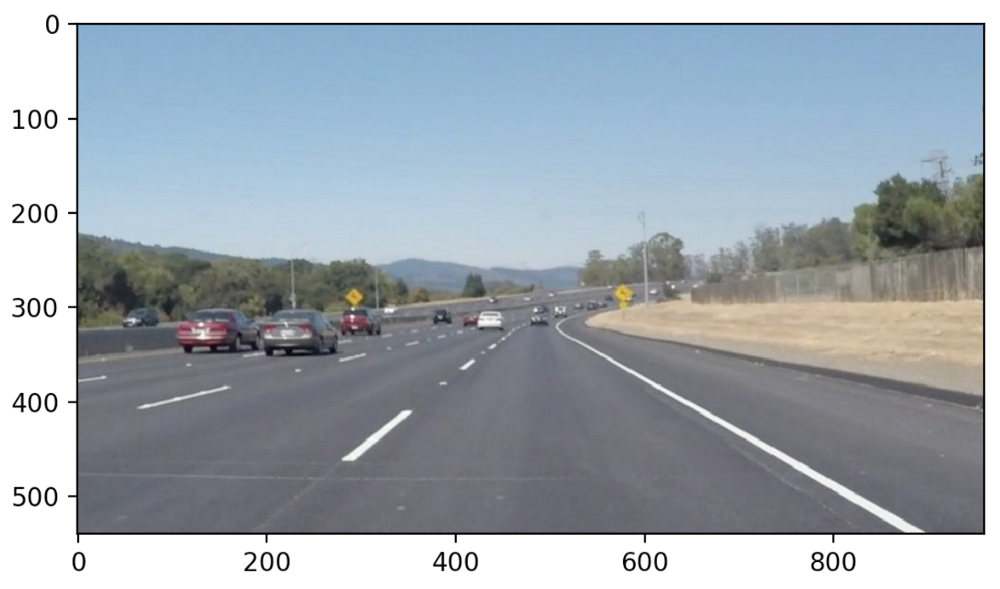

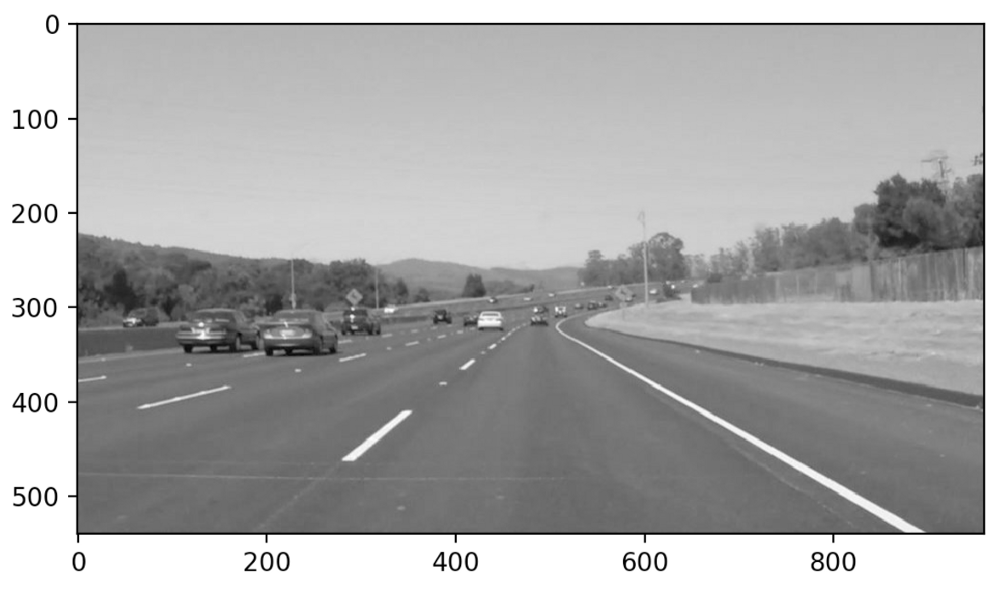

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

path = '/content/drive/My Drive/돈과 유명세를 잡자/Zumi/lane_extract/{num}.png'
src = cv2.imread(path.format(num=3))
gray= cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)

cv2_imshow(src)
cv2_imshow(gray)

# 관심 영역 추출
전체 화면에서 차선 정보를 찾는 것은 불필요한 영역도 탐색하게 되며 연산 자원과 배터리를 낭비합니다. 관심 영역을 지정해주면 연산량을 줄일 수 있습니다.

하늘이나 건물 등은 우리의 관심 영역이 아닙니다. 투시에 따라 삼각형을 형성하고 있습니다. 화면의 양쪽 밑단과 화면 중심을 이은 삼각형으로 대략적인 관심 영역을 마스킹 해봅시다.

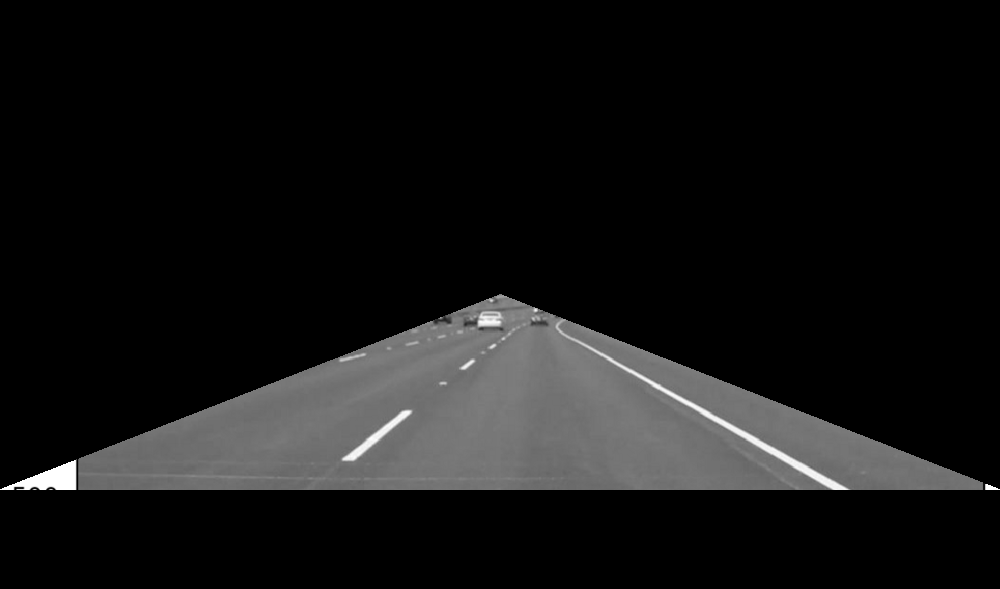

In [4]:
height, width = gray.shape
interest_vertices = np.asarray([[
    (0, height-100),
    (width // 2, height // 2),
    (width, height-100),
]])

mask = np.zeros_like(gray)
mask_color = (255,)

cv2.fillPoly(mask, interest_vertices, mask_color)
cropped = cv2.bitwise_and(gray, mask)
cv2_imshow(cropped)

# 크롭된 이미지에서 엣지 검출하기
이제 검은 도로에서 하얀색 차선 정보를 검출해봅시다. 도로와 차선의 색상 차이가 크기 때문에, 이미지를 Grayscale로 변환한 뒤 `Canny Edge 검출기`를 사용하면 엣지를 찾아낼 수 있습니다.

`Canny`의 첫 번째 매개변수는 이미지, 두 번째는 Minimum Thresholding Value, 세 번째는 Maximum Thresholding Value입니다. Minimum Thresholding Value를 넘지 못하는 픽셀 값은 무조건 버려지며, Maximum Thresholding Value를 넘는 픽셀 값은 무조건 엣지로 검출됩니다.

두 값 사이에 위치하는 픽셀은 Maximum Thresholding Value를 넘는 픽셀과 연결되어 있을 경우에만 엣지로 검출됩니다. 해당 값은 이미지 상황에 따라 하드코딩 하였습니다.

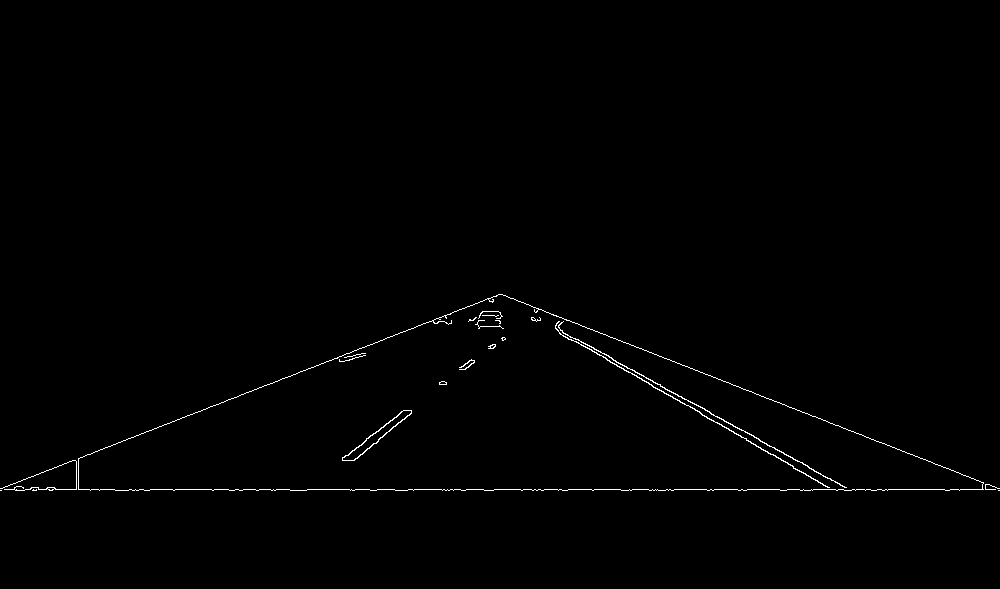

In [5]:
cannyed = cv2.Canny(cropped, 200, 300)
cv2_imshow(cannyed)

# 엣지로부터 라인 생성하기
엣지를 추출했으니 이제 차선을 연결하여 진행 방향을 표시해야 합니다. 이를 위해 허프 변환을 사용합니다. 허프 변환을 위해서는 먼저 직선을 표현하는 다른 방법을 알아야 하는데요.

![line](https://mblogthumb-phinf.pstatic.net/20160105_162/samsjang_1451982347519IqVaP_PNG/%C4%B8%C3%B3.PNG?type=w2)

점 (a,b)를 지나고 원점에서 직선까지 거리가 r이며, x축의 기울어진 각을 theta라고 하면, 직선의 방정식은 다음과 같습니다.

![r = a cos theta + b sin theta](https://mblogthumb-phinf.pstatic.net/20160105_33/samsjang_1451982508442VDJdD_PNG/%C4%B8%C3%B32.PNG?type=w2)

점 (a,b)를 지나는 직선은 무수히 많지만 각각의 직선은 고유한 (r, theta)를 가지고 있습니다. 두 점이 존재할 때, 한 점의 각도를 돌려가며 다른 점을 지나는지 측정합니다. 두 점을 지나는 시점의 (r, theta) 역시 고유합니다.

![same](https://mblogthumb-phinf.pstatic.net/20160105_191/samsjang_1451983730087lswjr_PNG/%C4%B8%C3%B36.PNG?type=w2)

이것이 허프 변환의 기본 원리라고 합니다. 모든 픽셀에 대해 (r, theta)를 카운팅하고, 가장 많이 카운팅 된 (r, theta)를 확률적으로 직선이라고 판단합니다.

`HoughLinesP`를 이용하여 라인의 양 쪽 점을 리스트로 얻을 수 있습니다. 00는 00고, 00는 00입니다.

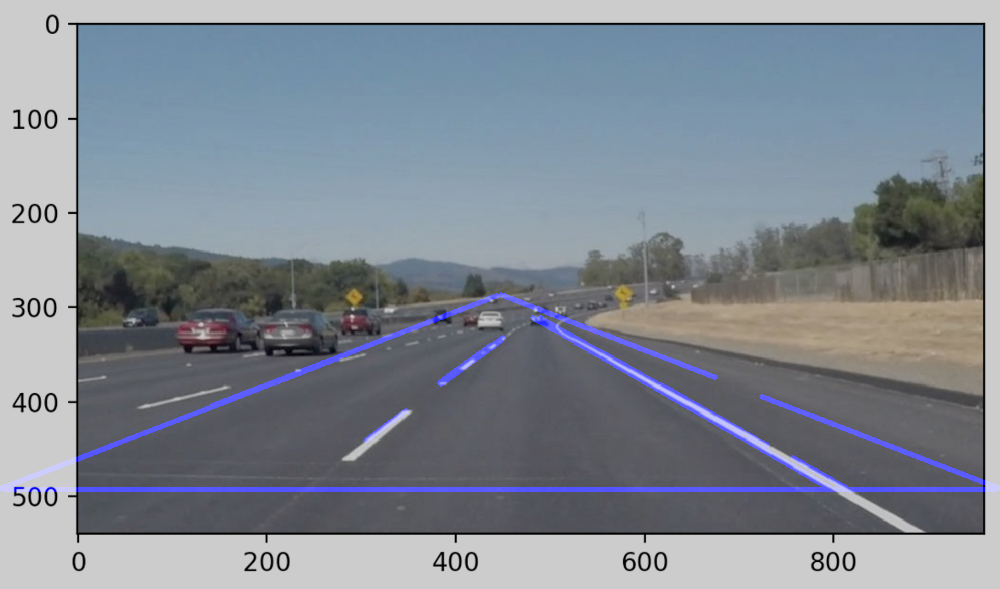

In [6]:
lines = cv2.HoughLinesP(
    cannyed,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)

line_painted = np.zeros((height, width, 3), dtype=np.uint8)
for line in lines:
  for x1, y1, x2, y2 in line:
    cv2.line(line_painted, (x1, y1), (x2, y2), color=[255, 0, 0], thickness=3)
    
line_painted = cv2.addWeighted(src, 0.8, line_painted, 1.0, 0.0)
cv2_imshow(line_painted)